<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

###Load Libraries

In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler

###Define Functions to Facilitate Metrics Evaluation

In [54]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [571]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [572]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [573]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

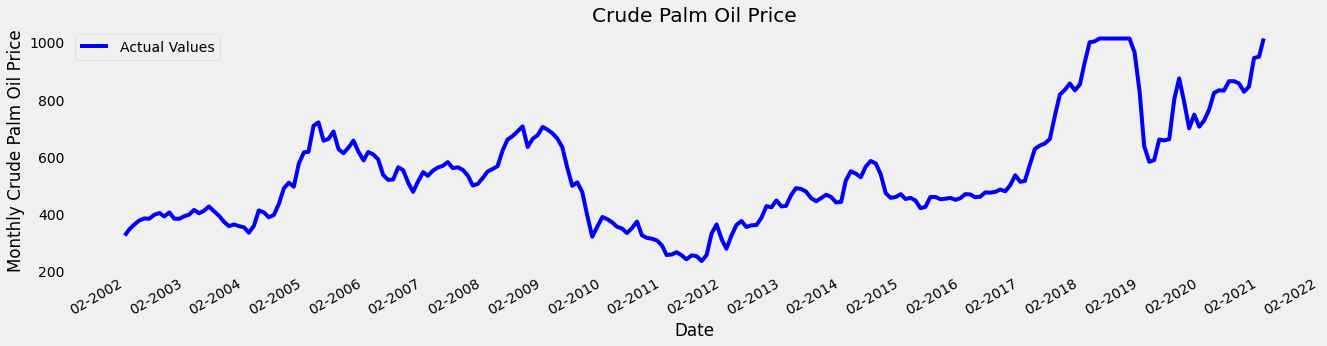

In [574]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [575]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

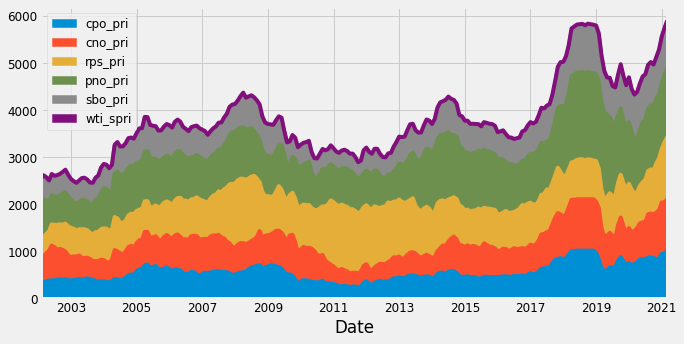

In [576]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [577]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 207
Test size: 23


###Plot Train Test Data

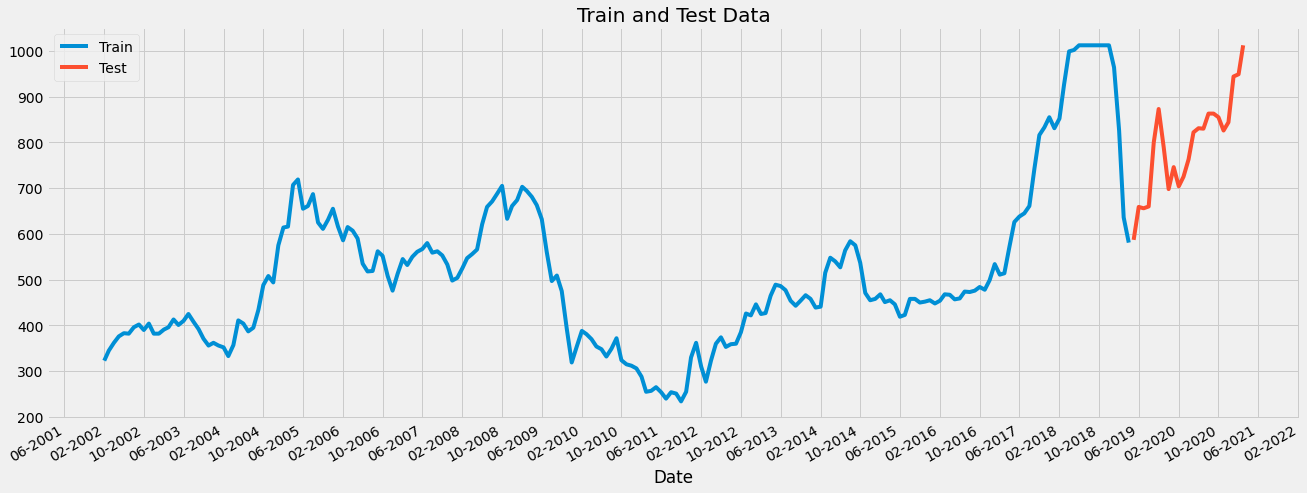

In [578]:
#Plotting data
plt.figure(figsize=(20,8))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [579]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

207 23


In [580]:
print(train.shape)
train.head()

(207, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [581]:
f_transformer = RobustScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,-0.706897,-1.632538,-0.361424,-0.461118,-0.835276
2002-03-01,345.0,-0.314655,-1.661990,-0.505341,-0.364340,-0.997669
2002-04-01,362.0,-0.103448,-1.681677,-0.764392,-0.472504,-1.092075
2002-05-01,376.0,0.073276,-1.665982,-1.097000,-0.609131,-1.108392
2002-06-01,383.0,0.512931,-1.525616,-1.081009,-0.683138,-1.082751


In [582]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.781491
2002-03-01   -0.668380
2002-04-01   -0.580977
2002-05-01   -0.508997
2002-06-01   -0.473008
Name: cpo_pri, dtype: float64

In [583]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2019-05-01,587.0,0.521552,-0.111882,2.573494,1.118923,-0.277778
2019-06-01,659.0,0.495690,-0.018214,2.119931,1.371342,-0.196193
2019-07-01,656.0,0.232759,0.002170,1.874856,1.130821,-0.068376
2019-08-01,660.0,0.025862,0.126996,1.849207,1.034442,0.049728
2019-09-01,800.0,0.551724,0.226166,1.522291,1.480587,0.258741


In [584]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2019-05-01    0.575835
2019-06-01    0.946015
2019-07-01    0.930591
2019-08-01    0.951157
2019-09-01    1.670951
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [585]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(206, 1, 6) (206,)


In [586]:
test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["Date"]).unstack().shift(3).stack()

###Create Model

In [528]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [590]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2]))) #64,32, 16, 8 (best so far)
cnn_model.add(Dropout(0.09))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=1))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(4, activation='relu')) #32, 8,4
#cnn_model.add(Dropout(0.1))
cnn_model.add(tf.keras.layers.Dense(1))
#cnn_model.add(Dropout(0.25))
#Dropout(droprate)
cnn_model.compile(loss='mse', optimizer='adam')
cnn_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 1, 8)              56        
                                                                 
 dropout_20 (Dropout)        (None, 1, 8)              0         
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 1, 8)             0         
 g1D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 8)                 0         
                                                                 
 dense_76 (Dense)            (None, 4)                 36        
                                                                 
 dense_77 (Dense)            (None, 1)                 5         
                                                     

In [591]:
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
7/7 [==============================] - 1s 24ms/step - loss: 0.9192 - val_loss: 2.6317
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.8337 - val_loss: 2.4747
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.8116 - val_loss: 2.3122
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8000 - val_loss: 2.1552
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.7166 - val_loss: 2.0005
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 0.6837 - val_loss: 1.8535
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6711 - val_loss: 1.7153
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6518 - val_loss: 1.5776
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6233 - val_loss: 1.4484
Epoch 10/50
7/7 [==============================] - 0s 6ms/step - loss: 0.5599 - val_loss: 1.3209
Epoch 11/50
7/7 [=====================

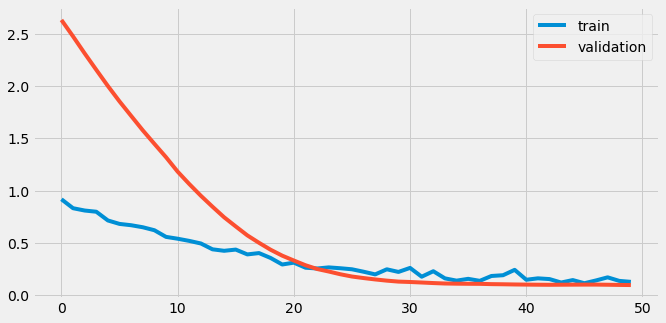

In [592]:
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

###Predict the test data

In [593]:
y_pred = cnn_model.predict(X_test)
y_pred

array([[0.8898313],
       [1.1311411],
       [0.9197225],
       [0.8205157],
       [1.3102628],
       [1.7085993],
       [1.5651329],
       [1.2564743],
       [1.5479478],
       [1.2745557],
       [1.3351941],
       [1.4406774],
       [1.5703365],
       [1.6289756],
       [1.7001513],
       [2.1013465],
       [2.2145188],
       [2.0258565],
       [2.0584693],
       [2.2459564],
       [2.5606842],
       [2.6303897]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [594]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[ 345.    362.    376.    383.    382.    396.    402.    390.    404.
   382.    382.    391.    396.    413.    401.    410.    425.    408.
   392.    371.    356.    362.    356.    352.    333.    357.    411.
   404.    387.    395.    434.    488.    508.    494.    575.    614.
   616.    707.    719.    655.    661.    687.    625.    611.    631.
   655.    616.    586.    615.    607.    590.    535.    518.    519.
   562.    552.    508.    476.    513.    545.    532.    550.    561.
   567.    580.    559.    562.    553.    533.    498.    504.    525.
   547.    556.    566.    621.    659.    671.    688.    705.    633.
   661.    674.    703.    694.    681.    663.    632.    561.    497.
   509.    475.    392.    319.    354.    388.    381.    370.    354.
   348.    332.    349.    372.    324.    315.    312.    306.    288.
   255.    257.    265.    254.    240.    254.    251.    234.    255.
   330.    362.    310.    277.    323.    360.    374.    353. 

###Plot history, actual and predicted value

In [595]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [596]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([648.0722 , 695.00696, 653.88605, 634.59033, 729.8461 , 807.3226 ,
       779.41833, 719.3843 , 776.0758 , 722.90106, 734.69525, 755.2118 ,
       780.4304 , 791.83575, 805.67944, 883.7119 , 905.7239 , 869.02905,
       875.3723 , 911.8385 , 973.0531 , 986.61084], dtype=float32)

###Plot Actual and Predicted Value 

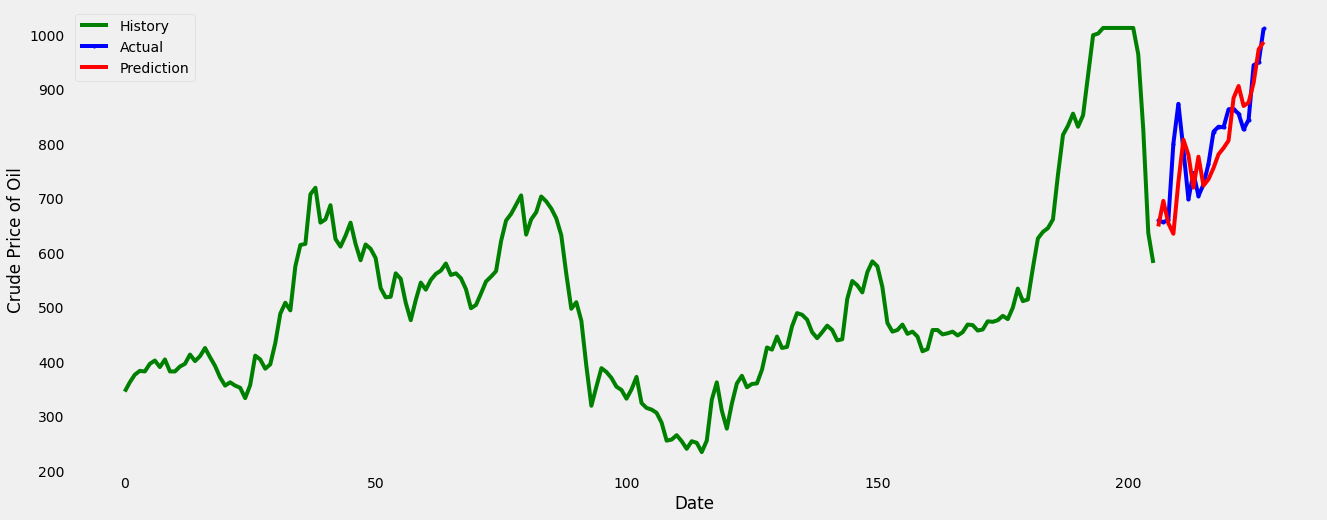

In [597]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Date')
plt.legend()
plt.show();

###Plot Actual and Predicted Value Zoomed-In

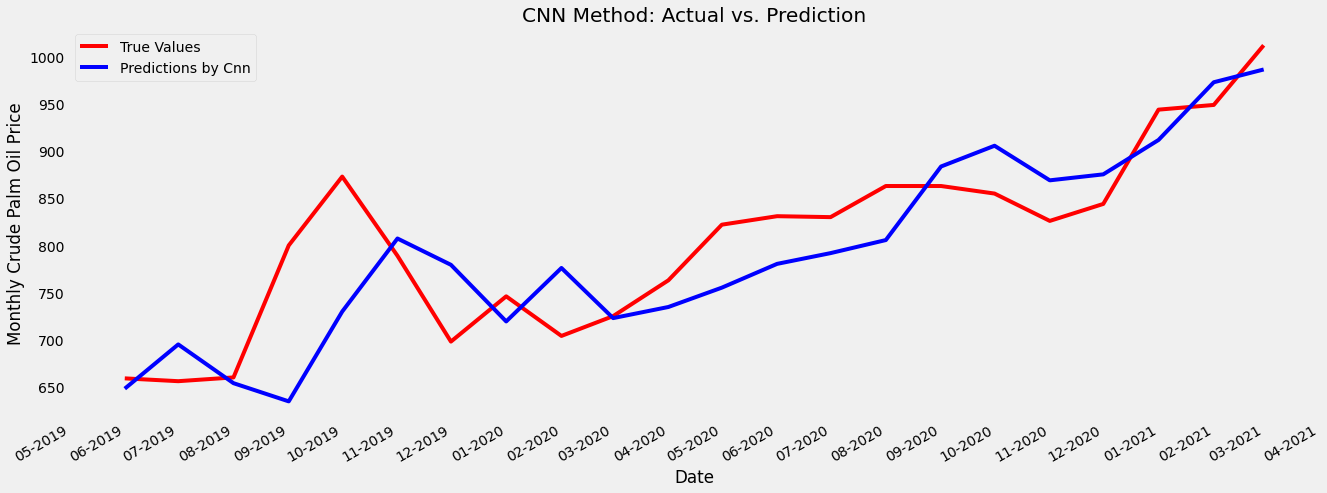

In [598]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(test_lag.index, y_test_inv, color = 'red',  label = 'Test')
plt.plot(test_lag.index,  y_pred_inv, color = 'blue',label = 'CNN Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by Cnn', 'CNN Prediction'],loc='best')
plt.title('CNN Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Evaluate MLP Model Accuracy

In [599]:
MAEcnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAEcnn)

MDAcnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDAcnn)

MAPEcnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPEcnn)

RMSEcnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSEcnn)

MSEcnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSEcnn)

EVScnn = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVScnn)

MAE value of the SVR Model is: 46.999176025390625
MDA value of the SVR Model is: 0.5238095238095238
MAPE value of the SVR Model is: 5.844577658797214
RMSE value of the SVR Model is: 61.449636802303885
MSE value of the SVR Model is: 3776.05786313506
EVS score of the MLP Model is: 0.598568902545334


In [ ]:
'''
###Apply Grid Search
seed = 7
np.random.seed(seed)
print ("Regressor")
model = KerasRegressor(build_fn = create_model, verbose = 10)
init_mode_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation_mode_list = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
activation_mode_list_conv =  ['softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer_mode_list = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size_list = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(init_mode=init_mode_list, batch_size=batch_size_list, nb_epoch=epochs, activation_mode=activation_mode_list, optimizer_mode = optimizer_mode_list, activation_mode_conv =  activation_mode_list_conv)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
print ("Grid fit")
grid_result = grid.fit(np.asarray(input_train), np.array(output_train))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\n###Apply Grid Search\nseed = 7\nnp.random.seed(seed)\nprint ("Regressor")\nmodel = KerasRegressor(build_fn = create_model, verbose = 10)\ninit_mode_list = [\'uniform\', \'lecun_uniform\', \'normal\', \'zero\', \'glorot_normal\', \'glorot_uniform\', \'he_normal\', \'he_uniform\']\nactivation_mode_list = [\'softmax\', \'softplus\', \'softsign\', \'relu\', \'tanh\', \'sigmoid\', \'hard_sigmoid\', \'linear\']\nactivation_mode_list_conv =  [\'softplus\', \'softsign\', \'relu\', \'tanh\', \'sigmoid\', \'hard_sigmoid\', \'linear\']\noptimizer_mode_list = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nbatch_size_list = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(init_mode=init_mode_list, batch_size=batch_size_list, nb_epoch=epochs, activation_mode=activation_mode_list, optimizer_mode = optimizer_mode_list, activation_mode_conv =  activation_mode_list_conv)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)\npr